In [4]:
import os
import sys
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as ocm
from matplotlib import rcParams
import pandas as pd

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
fig_dir = os.path.join(proj_dir,'reports','devel','figures')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)

from log_progress import log_progress
from visualization.shiftedColorMap import shiftedColorMap
from calc_antarctic_mass_loss import calc_antarctic_mass_loss
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves
from make_grd_dV import make_grd_dV

In [5]:
waom10_avg_path = os.path.join(data_dir,'raw','waom10','ocean_avg_0009.nc')
avg10 = xr.open_mfdataset(waom10_avg_path)

waom10_grd_path = os.path.join(data_dir,'interim','grd10_dV.nc')
grd10 = xr.open_mfdataset(waom10_grd_path)

waom4_his_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0009.nc')
avg4 = xr.open_mfdataset(waom4_his_path,chunks={'eta_rho':180,'xi_rho':180})

waom4_grd_path = os.path.join(data_dir,'interim','grd4_dV.nc')
grd4 = xr.open_mfdataset(waom4_grd_path)

waom2_his_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
temp2 = xr.open_mfdataset(waom2_his_path,chunks={'eta_rho':180,'xi_rho':180}).temp

waom2_his_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_m_avg.nc')
m2 = xr.open_mfdataset(waom2_his_path,chunks={'eta_rho':180,'xi_rho':180}).m

waom2_grd_path = os.path.join(data_dir,'interim','grd2_dV.nc')
grd2 = xr.open_mfdataset(waom2_grd_path)

In [6]:
def make_mask(grd,eta,xi):
    mask_sector = make_mask_sector(grd)
    mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500)['Total Antarctica'].load() 
    mask_shelf[:,xi:]=0
    mask_shelf[eta:,:]=0
    
    return mask_shelf
    
mask_shelf={}
for name,grd,eta,xi in [['10',grd10,500,600],['4',grd4,1250,1500],['2',grd2,2500,3000]]:
    mask_shelf[name] = make_mask(grd,eta,xi)

In [7]:
from scipy.interpolate import griddata

def regrid(sgrd,sda,tgrd):
    
#tamura comes from npstereo curvilinear grid
#we need to find points close to the 0/360 gap, wrap them and add them to the list for source points
# otherwise we get an interpolation gap between 0/360
    slon = sgrd.lon_rho.values.flatten()
    slat = sgrd.lat_rho.values.flatten()
    sdat = sda.values.flatten()
    tlon=tgrd.lon_rho.values
    tlat=tgrd.lat_rho.values

    tdat =griddata((slon,slat),sdat,(tlon,tlat),'linear')
    tda = xr.DataArray(tdat,dims=['eta_rho','xi_rho'])
    
    return tda

In [6]:
def plot_temp_map(temp_from,temp_to,grd,title,t_min=-1,t_max=1,out_path=None,cb_ext='both',ls='large'):
    
    mask_sector = make_mask_sector(grd)
    mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    
    land = (grd.mask_rho==0)
    
    temp_diff = (temp_to-temp_from)
    
    plt.close()
    fig,ax = plt.subplots(ncols=1,figsize=(11,11))
    
    ax.contourf(grd.mask_rho.where(land).values,colors=(('0.6','0.6','0.6')))
    ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
    ax.contour(mask_shelf['Total Antarctica'].where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
    ax.set_aspect('equal')
    ax.axis('off')


    cp = temp_diff.where(~land)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax,cmap=ocm.balance,add_colorbar=False)
    cb = plt.colorbar(cp, ax=ax, orientation="horizontal", pad=0.01, extend=cb_ext)
    cb.set_label(label='Potential temperature difference in $^{\circ}$C', size=ls, weight='bold')
    cb.ax.tick_params(labelsize=ls)    
    ax.set_title(title,fontsize=ls, weight='bold')
    
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,dpi=300)
    plt.show()

In [8]:
def make_vol_avg(da,dV,mask):
    dV = dV.where(mask)
    weights = dV/dV.sum()
    
    return (da*weights).sum().load().values

def make_area_avg(da,dA,mask):
    dA = dA.where(mask)
    weights = dA/dA.sum()
    
    return (da*weights).sum().load().values

In [9]:
res = {'10':{},'4':{},'2':{}}
res['10']['temp'] = make_vol_avg(avg10.temp.mean('ocean_time'),grd10.dV,mask_shelf['10'])
res['4']['temp'] = make_vol_avg(avg4.temp.mean('ocean_time'),grd4.dV,mask_shelf['4'])
res['2']['temp'] = make_vol_avg(temp2.mean('ocean_time'),grd2.dV,mask_shelf['2'])

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [10]:
s2a = 365.25*24*3600
res['10']['m'] = make_area_avg(avg10.m.mean('ocean_time'),(grd10.pm*grd10.pn)**-1,
                               (mask_shelf['10'] == 1)&(grd10.zice<0))*s2a
res['4']['m'] = make_area_avg(avg4.m.mean('ocean_time'),(grd4.pm*grd4.pn)**-1,
                              (mask_shelf['4'] == 1)&(grd4.zice<0))*s2a
res['2']['m'] = make_area_avg(m2.mean('ocean_time'),(grd2.pm*grd2.pn)**-1,
                              (mask_shelf['2'] == 1)&(grd2.zice<0))*s2a

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, ou

In [11]:
resdf = pd.DataFrame(res).T.astype(float)

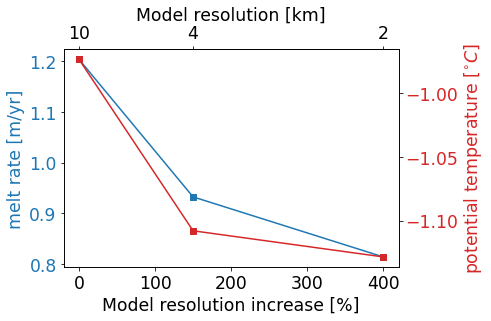

In [13]:
fig,ax1 = plt.subplots()

t=[0,150,400]
color='tab:blue'
ax1.plot(t,resdf.m,color=color,marker='s')
ax1.set_ylabel('melt rate [m/yr]',color=color,size='xx-large')
ax1.tick_params(axis='y',labelcolor=color,labelsize='xx-large')
ax1.set_xlabel('Model resolution increase [%]',size='xx-large')
ax1.tick_params(axis='x',labelcolor='k',labelsize='xx-large')

ax2 = ax1.twinx()
color='tab:red'
ax2.plot(t,resdf.temp,color=color,marker='s')
ax2.set_ylabel('potential temperature [$^{\circ}C$]',color=color,size='xx-large')
ax2.tick_params(axis='y',labelcolor=color,labelsize='xx-large')

secax = ax2.secondary_xaxis('top')
secax.set_xlabel('Model resolution [km]',size='xx-large')
secax.set_xticks([0,150,400])
secax.set_xticklabels(["10","4","2"])
secax.tick_params(axis='x',labelcolor='k',labelsize='xx-large')
plt.savefig(os.path.join(fig_dir,'gridConv.png'),dpi=300,format='png',bbox_inches = "tight")    
plt.show()

In [72]:


temp10_wc = avg10.temp.mean({'ocean_time','s_rho'})
temp4_wc = avg4.temp.mean({'ocean_time','s_rho'})
temp2_wc = temp2.mean({'ocean_time','s_rho'})

temp4on10_wc = regrid(grd4,temp4_wc,grd10)
temp2on4_wc = regrid(grd2,temp2_wc,grd4)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


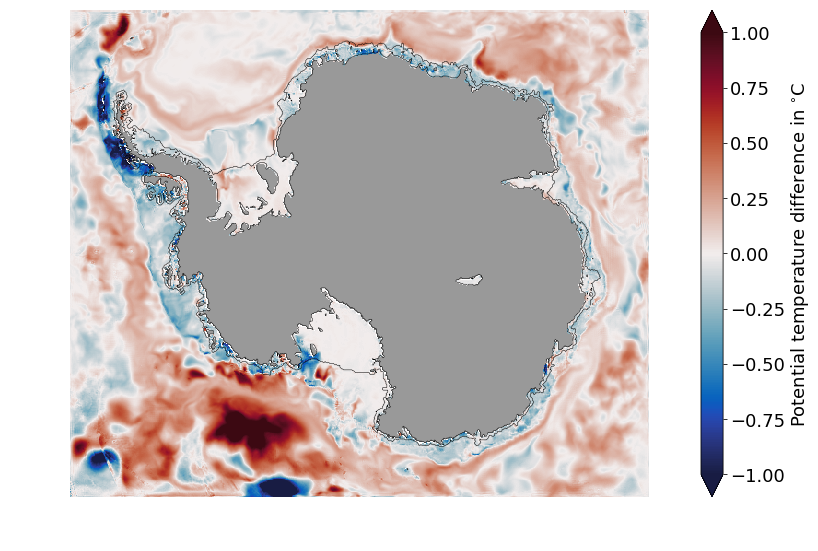

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


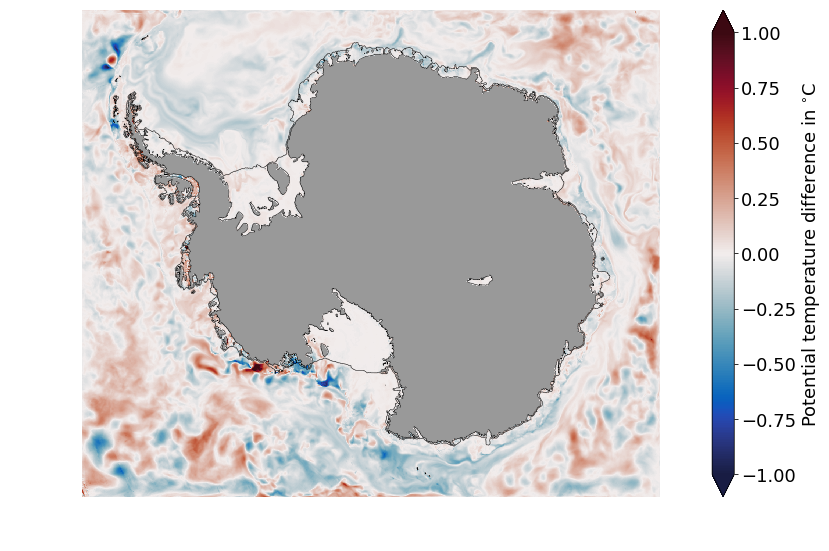

In [73]:
out_path = os.path.join(fig_dir,'10to4temp_wc.png')
plot_temp_map(temp10,temp4on10,grd10,'by increasing resolution from 10 km to 4 km', out_path = out_path)

out_path = os.path.join(fig_dir,'4to2temp_wc.png')
plot_temp_map(temp4,temp2on4,grd4,'by increasing resolution from 4 km to 2 km',out_path = out_path)

In [81]:
temp10_b = avg10.temp.isel(s_rho=0).mean('ocean_time')
temp4_b = avg4.temp.isel(s_rho=0).mean('ocean_time')
temp2_b = temp2.isel(s_rho=0).mean('ocean_time')

temp4on10_b = regrid(grd4,temp4_b,grd10)
temp2on4_b = regrid(grd2,temp2_b,grd4)

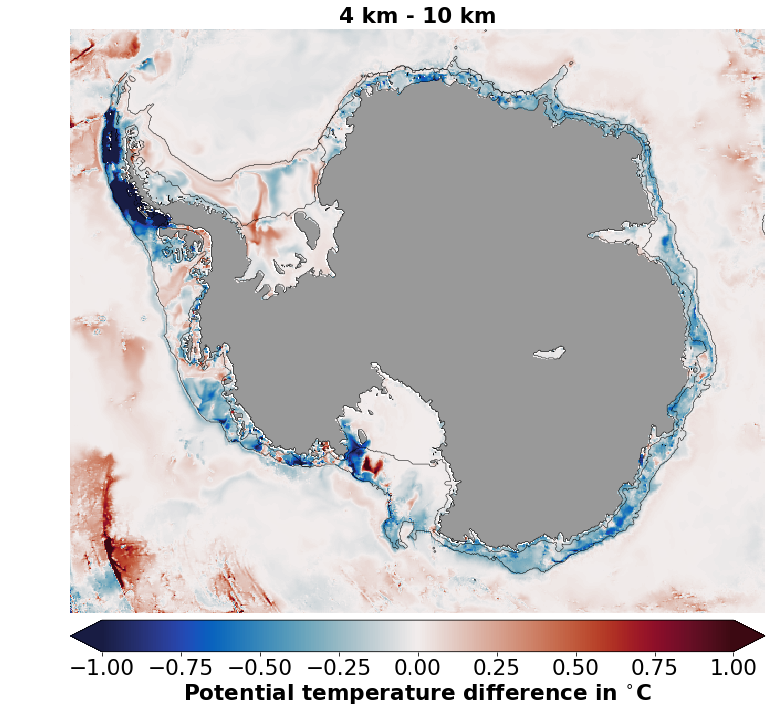

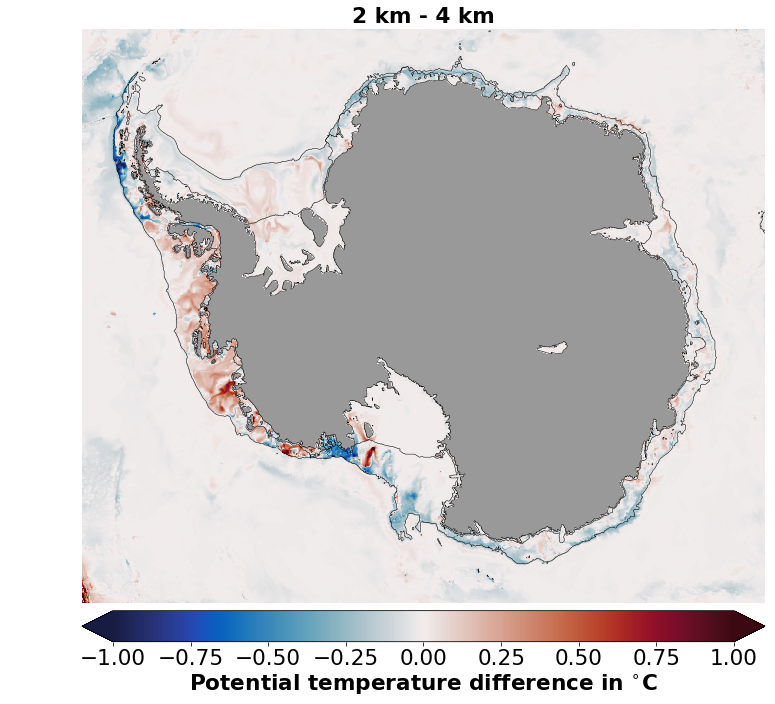

In [231]:
out_path = os.path.join(fig_dir,'10to4temp_b.png')
plot_temp_map(temp10_b,temp4on10_b,grd10,'4 km - 10 km', out_path = out_path)

out_path = os.path.join(fig_dir,'4to2temp_b.png')
plot_temp_map(temp4_b,temp2on4_b,grd4,'2 km - 4 km',out_path = out_path)

In [87]:
def make_mask_shelf_grd(grd):
    mask_sector = make_mask_sector(grd)
    return make_mask_shelf_sector(grd,mask_sector,1500)

def make_sec_avg(da,grd,cavity='include'):
    mask_shelf = make_mask_shelf_grd(grd)
    ser = pd.Series()
    for k,v in log_progress(mask_shelf.items(),every=2):          
        dA = ((grd.pm*grd.pn)**-1).where(v)
        print(dA.sum())
        weights = dA/dA.sum()
        ser[k] = (da*weights).sum().values
        
    return ser.astype(float)

In [ ]:
sec_temp_10_wc = make_sec_avg(temp10_wc,grd10)
sec_temp_4_wc = make_sec_avg(temp4_wc,grd4)
sec_temp_2_wc = make_sec_avg(temp2_wc,grd2)

In [100]:
sec_temp_10_b = make_sec_avg(temp10_b,grd10)
sec_temp_4_b = make_sec_avg(temp4_b,grd4)
sec_temp_2_b = make_sec_avg(temp2_b,grd2)

<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>


<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>


<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>


In [95]:
sec_melt_10 = make_sec_avg(avg10.m.mean('ocean_time'),grd10)
sec_melt_4 = make_sec_avg(avg4.m.mean('ocean_time'),grd4)
sec_melt_2 = make_sec_avg(m2.mean('ocean_time'),grd2)

<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>


<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>


<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>


In [98]:
s2a = 365.25*24*3600
sec_melt = pd.DataFrame({"10 km":sec_melt_10,"4 km ":sec_melt_4,"2 km":sec_melt_2})*s2a

In [46]:
sec_temp = pd.DataFrame({"10 km":sec_temp_10,"4 km ":sec_temp_4,"2 km":sec_temp_2})

In [99]:
sec_melt

10 km     4 km       2 km
Total Antarctica                        0.497247  0.342784  0.286448
Western East Antarctica                 1.340260  0.644807  0.480782
Amery/Prydz Bay                         0.193602  0.112304  0.092363
Sabrina Coast/Aurora subglacial basin   0.622259  0.359766  0.289672
George V Coast/Wilkes subglacial basin  0.417295  0.222718  0.179276
Ross Sea                                0.304516  0.245501  0.171382
Amundsen Sea                            0.875876  0.625405  0.596039
Bellingshausen Sea                      1.056701  0.830793  0.707483
Weddell Sea                             0.193558  0.173759  0.161125

In [47]:
sec_temp

10 km     4 km       2 km
Total Antarctica                       -1.039026 -1.193124 -1.201664
Western East Antarctica                -0.972433 -1.242926 -1.313353
Amery/Prydz Bay                        -1.582709 -1.683695 -1.695590
Sabrina Coast/Aurora subglacial basin  -0.966476 -1.188159 -1.207768
George V Coast/Wilkes subglacial basin -0.777209 -1.076143 -1.153824
Ross Sea                               -1.460339 -1.546688 -1.582357
Amundsen Sea                           -0.124243 -0.269238 -0.145210
Bellingshausen Sea                      0.441746  0.106527  0.160098
Weddell Sea                            -1.438325 -1.527838 -1.543450

In [20]:
grd10_dV = make_grd_dV(grd10,avg10.zeta.mean('ocean_time'))
grd4_dV = make_grd_dV(grd4,avg4.zeta.mean('ocean_time'))

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [21]:
waom2_zeta_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')
zeta2 = xr.open_mfdataset(waom2_zeta_path)
grd2_dV = make_grd_dV(grd2,zeta2.zeta.mean('ocean_time'))

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][1050:1140,95:113] = True

grd.mask_rho[570:610,1030:1140] = False

In [ ]:
def make_sec_avg(da,cavity='exclude'):
    ser = pd.Series()
    for k,v in log_progress(mask_shelf.items(),every=2):
        if cavity=='only':
            mask = (v == 1) & (grd.zice < 0)
        elif cavity=='include':
            mask = (v == 1)
        elif cavity=='exclude':
            mask = (v == 1) & (grd.zice == 0)
            
        dA = ((grd.pm*grd.pn)**-1).where(mask)
        weights = dA/dA.sum()
        ser[k] = (da*weights).sum().values
    return ser.astype(float)

In [7]:
def plot_ismr_temp_map(m,temp,grd,title_str,m_min=-1,m_max=1,t_min=-1,t_max=1,out_path=None):

    s2a = 3600*24*365.25
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)
    
    plt.close()
    fig,ax = plt.subplots(figsize=(15,8))
    ax.contourf(grd.mask_rho.where(land_zice).values[1:-1,1:-1],colors=(('0.6','0.6','0.6')))
    (m.where(mask)*s2a)[1:-1,1:-1].plot(vmin=m_min,vmax=m_max,ax=ax,cmap=plt.cm.seismic,cbar_kwargs={'label':'melt rate difference in m/yr'})
    temp.where(~land_zice)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax,cmap=ocm.balance,cbar_kwargs={'label':'temperature difference  in degC'})
    ax.contour(-grd.zice.where(grd.mask_rho).values[1:-1,1:-1], levels=['0.01'], colors=('black'),linewidths=0.5)
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
    plt.title('Difference in basal melting and bottom layer temperature \n'+title_str, fontsize=20)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path)
    plt.show()

In [9]:
def plot_temp_map(temp,grd,title_str,t_min=-1,t_max=1,out_path=None):

    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    
    land = (grd.mask_rho==0)
    rcParams.update({'font.size': 18})
    plt.close()
    fig,ax = plt.subplots(figsize=(15,8))
    ax.contourf(grd.mask_rho.where(land).values[1:-1,1:-1],colors=(('0.6','0.6','0.6')))
    temp.where(~land)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax,cmap=ocm.balance,cbar_kwargs={'label':'temperature difference  in degC'})
    ax.contour(-grd.zice.where(grd.mask_rho).values[1:-1,1:-1], levels=['0.01'], colors=('black'),linewidths=0.5)
    ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
    plt.title('Difference in bottom layer temperature \n'+title_str, fontsize=20)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,format='png',dpi=300)
    plt.show()

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


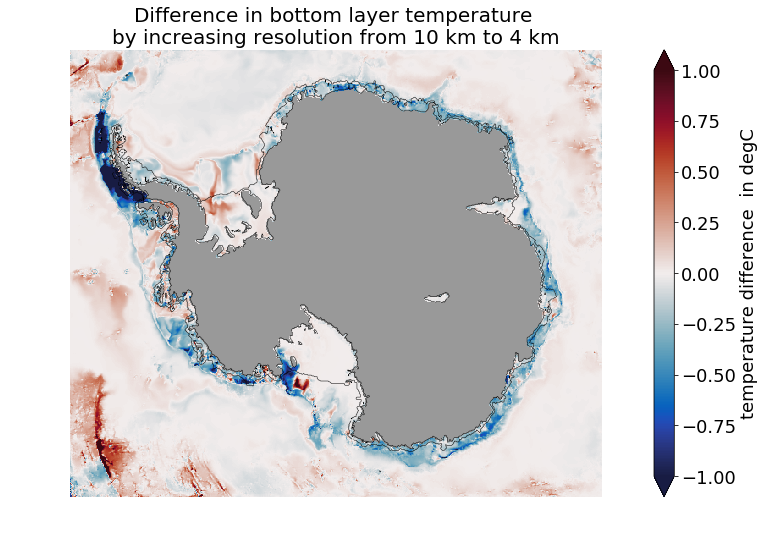

In [10]:
%matplotlib inline
out_path = os.path.join(fig_dir,'10to4Temp.png')
plot_temp_map(temp_10to4,grd10,'by increasing resolution from 10 km to 4 km')

In [ ]:
def plot_ismr_temp_diff_map(avg_from,avg_to,grd,m_min=-1,m_max=1,p_min=-1000,p_max=1000,out_path=None):

    s2a = 3600*24*365.25
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)

    m_diff = (m_to-m_from)*s2a
    m_diff_rel = (m_to-m_from)/m_from*100

    plt.close()
    fig,axes = plt.subplots(ncols=2,figsize=(20,8))
    ax1,ax2 = axes.flatten()
    for ax in axes:
        ax.contourf(grd.mask_rho.where(land_zice).values,colors=(('0.6','0.6','0.6')))
        ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.set_aspect('equal')
        ax.axis('off')


    (m_diff.where(mask).mean('ocean_time')).plot(vmin=m_min,vmax=m_max,ax=ax1,cmap=plt.cm.seismic)
    temp.where(~land_zice)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax,cmap=ocm.balance,cbar_kwargs={'label':'temperature difference  in degC'})
    ax1.set_title('Melt rate difference (m/y), annual average', fontsize=20)
    (m_diff_rel.where(mask).mean('ocean_time')).plot(vmin=p_min,vmax=p_max,ax=ax2,cmap=plt.cm.seismic)
    ax2.set_title('Relative melt rate difference (%), annual average', fontsize=20)
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,bbox_tight=True)

    plt.show()


In [133]:
xr.ufuncs.fabs(avg10.m.mean('ocean_time')).min().values

array(0., dtype=float32)

In [144]:
def plot_ismr_temp_map(m_from,m_to,temp_from,temp_to,grd,title_str,m_min=-1,m_max=1,t_min=-1,t_max=1,tp_min=-100,tp_max=100,mp_min=-500,mp_max=500,out_path=None):

    s2a = 3600*24*365.25
    mask = (grd.zice < 0.0)&(grd.mask_rho==1)
    
    land_zice = (grd.mask_rho==0) | (grd.zice < 0.0)
    
    m_diff = (m_to-m_from)*s2a
    m_diff_rel = (m_to-m_from)/xr.ufuncs.fabs(m_from)*100
    
    temp_diff = (temp_to-temp_from)
    temp_diff_rel = (temp_to-temp_from)/xr.ufuncs.fabs(temp_from)*100
    
    plt.close()
    fig,axes = plt.subplots(ncols=2,figsize=(25,8))
    ax1,ax2 = axes.flatten()
    for ax in axes:
        ax.contourf(grd.mask_rho.where(land_zice).values,colors=(('0.6','0.6','0.6')))
        ax.contour(-grd.zice.where(grd.mask_rho).values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.contour(grd.mask_rho.values, levels=['0.01'], colors=('black'),linewidths=0.5)
        ax.set_aspect('equal')
        ax.axis('off')

    (m_diff.where(mask))[1:-1,1:-1].plot(vmin=m_min,vmax=m_max,ax=ax1,cmap=plt.cm.seismic,cbar_kwargs={'label':'melt rate difference in m/yr'})
    temp_diff.where(~land_zice)[1:-1,1:-1].plot(vmin=t_min,vmax=t_max,ax=ax1,cmap=ocm.balance,cbar_kwargs={'label':'temperature difference in degC'})
    ax1.set_title('Difference in melt rate (m/yr) and\n bottom layer temperature  (degC)',fontsize=20)
    (m_diff_rel.where(mask))[1:-1,1:-1].plot(vmin=mp_min,vmax=mp_max,ax=ax2,cmap=plt.cm.seismic,cbar_kwargs={'label':'melt rate relative difference in %'})
    temp_diff_rel.where(~land_zice)[1:-1,1:-1].plot(vmin=tp_min,vmax=tp_max,ax=ax2,cmap=ocm.balance,cbar_kwargs={'label':'temperature relative difference in %'})
    ax2.set_title('Relative difference in melt rate and\n bottom layer temperature (%)',fontsize=20)
    
    
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path,dpi=300)
    plt.show()

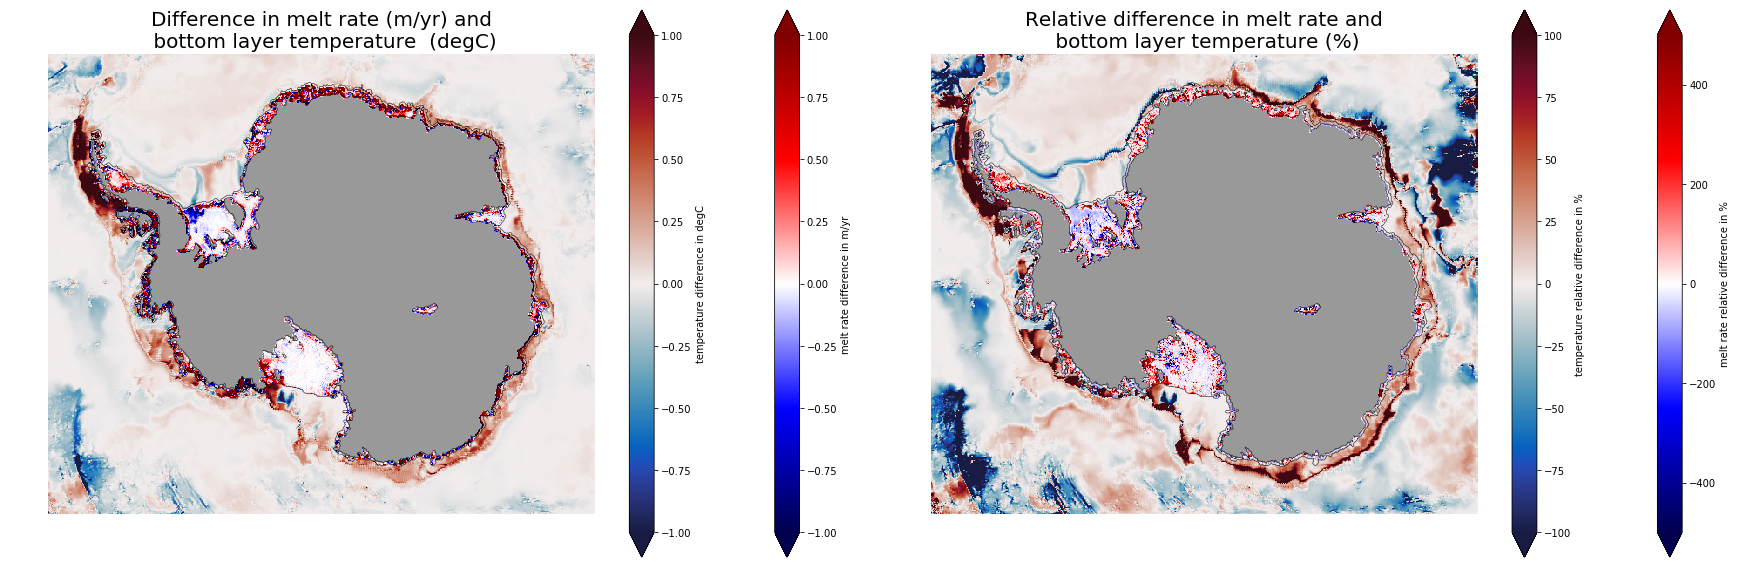

In [145]:
%matplotlib inline
out_path = os.path.join(proj_dir,'reports','figures','res10to4.png')
plot_ismr_temp_map(m_4,avg10.m.mean('ocean_time'),temp_4,avg10.temp.isel(s_rho=0).mean('ocean_time'),
                   grd10,'by increasing resolution from 10 km to 4 km',
                   out_path = out_path)

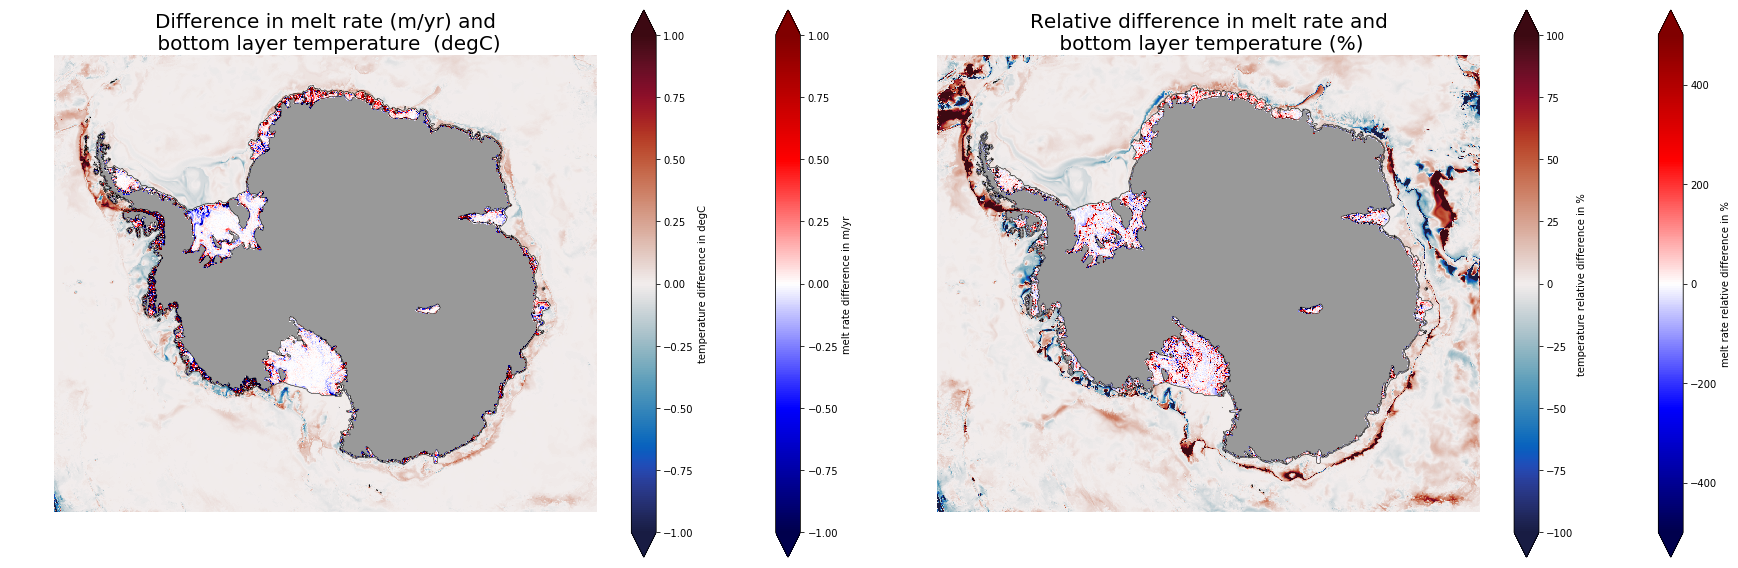

In [150]:
out_path = os.path.join(proj_dir,'reports','figures','res4to2.png')
plot_ismr_temp_map(m_2,avg4.m.mean('ocean_time'),temp_2,avg4.temp.isel(s_rho=0).mean('ocean_time'),
                   grd4,'by increasing resolution from 4 km to 2 km',
                  out_path = out_path)

In [94]:
# %load ../../src/tools/calc_antarctic_mass_loss.py

import xarray as xr

def calc_antarctic_mass_loss(m,grd):
    
    s2a = 3600*24*365.25
    rhoi = 916
    
    ice_shelf = (grd.mask_rho==1) & (grd.zice<0.0) 
    vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)
    
    mask = ice_shelf & ~vostock
    
    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()
    
    ismr = (m.where(mask)*weights*s2a).sum()
    bmb = (m.where(mask)*dA*rhoi*s2a*10**-12).sum()
    
    print('Area of all ice shelves in 10^3 km^2: ',dA.sum().values*10**-9)
    print('Area average melt rate in m/yr: ',ismr.values)
    print('Basal mass loss in Gt/a: ',bmb.values)
    


In [95]:
calc_antarctic_mass_loss(m_10to4,grd10)

Area of all ice shelves in 10^3 km^2:  1908.8416851122813
Area average melt rate in m/yr:  -0.39043729811067307
Basal mass loss in Gt/a:  -682.679218891537


In [16]:
waom4_his_path = os.path.join(data_dir,'raw','waom4','ocean_avg_0008.nc')
avg4 = xr.open_mfdataset(waom4_his_path)

waom4_grd_path = os.path.join(data_dir,'raw','waom_frc','waom4_grd.nc')
grd4 = xr.open_mfdataset(waom4_grd_path)

In [19]:
waom2_avg_path = os.path.join(data_dir,'raw','waom2_fix','bottom_temp.nc')
avg2 = xr.open_mfdataset(waom2_avg_path)

waom2_grd_path = os.path.join(data_dir,'raw','waom_frc','waom2_grd.nc')
grd2 = xr.open_mfdataset(waom2_grd_path)

In [20]:
temp_2 = regrid(grd2,avg2.temp.isel(s_rho=0).mean('ocean_time'),grd4)
temp_4to2 = temp_2 - avg4.temp.isel(s_rho=0).mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


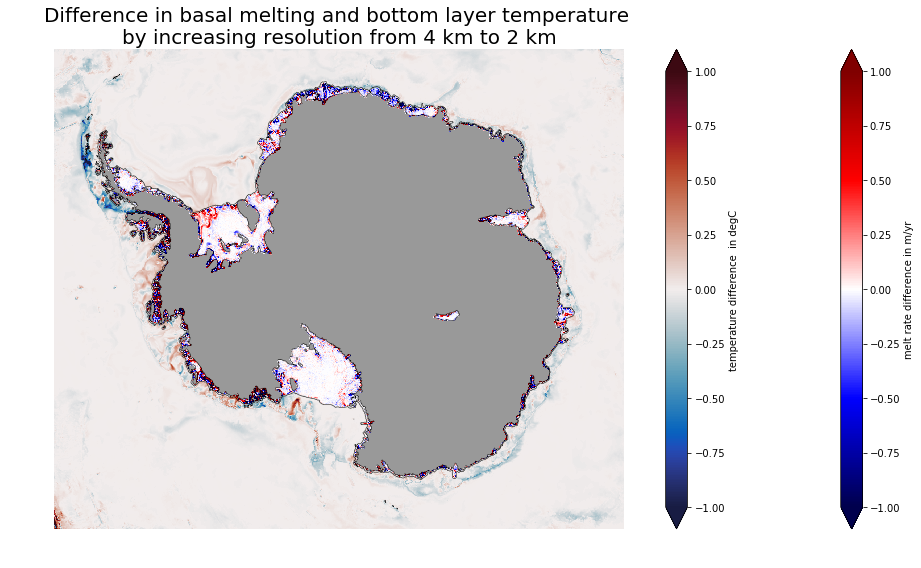

In [90]:
plot_ismr_temp_map(m_4to2,temp_4to2,grd4,'by increasing resolution from 4 km to 2 km')

In [149]:
calc_antarctic_mass_loss(m_4to2,grd4)

Area of all ice shelves in 10^3 km^2:  1690.8425444117272
Area average melt rate in m/yr:  -0.1391855771287541
Basal mass loss in Gt/a:  -215.57226016606234


In [28]:
%matplotlib notebook
m_min = -1
m_max = 6
m_cmap = shiftedColorMap(plt.cm.seismic,midpoint= (1 - m_max/(m_max + abs(m_min))))

temp_min = -2
temp_max = 1

s2a = 3600*24*365.25

def plot_m_bt(m_diff,temp_diff,grd):
    
    #plt.close()
    fig,ax = plt.subplots(figsize=(12,7))
    temp_diff.where((grd.mask_rho==1)&(grd.zice == 0)).plot(
    ax=ax,vmin=temp_min,vmax=temp_max,cmap=ocm.thermal,cbar_kwargs={'label':'temp in degC'})
    (waom.m.where((grd.mask_rho==1)&(grd.zice < 0))*s2a).plot(
    ax=ax,vmin=m_min,vmax=m_max,cmap=m_cmap,cbar_kwargs={'label':'ismr in m/yr'})
    ax.set_aspect('equal')
    ax.set_title(res+' km')
    ax.axis('off')
    ax.set_title('Bottom layer temperatures and melt rates for '+res+' km grid resolution')
    fig.tight_layout()
    #plt.show()

<IPython.core.display.Javascript object>


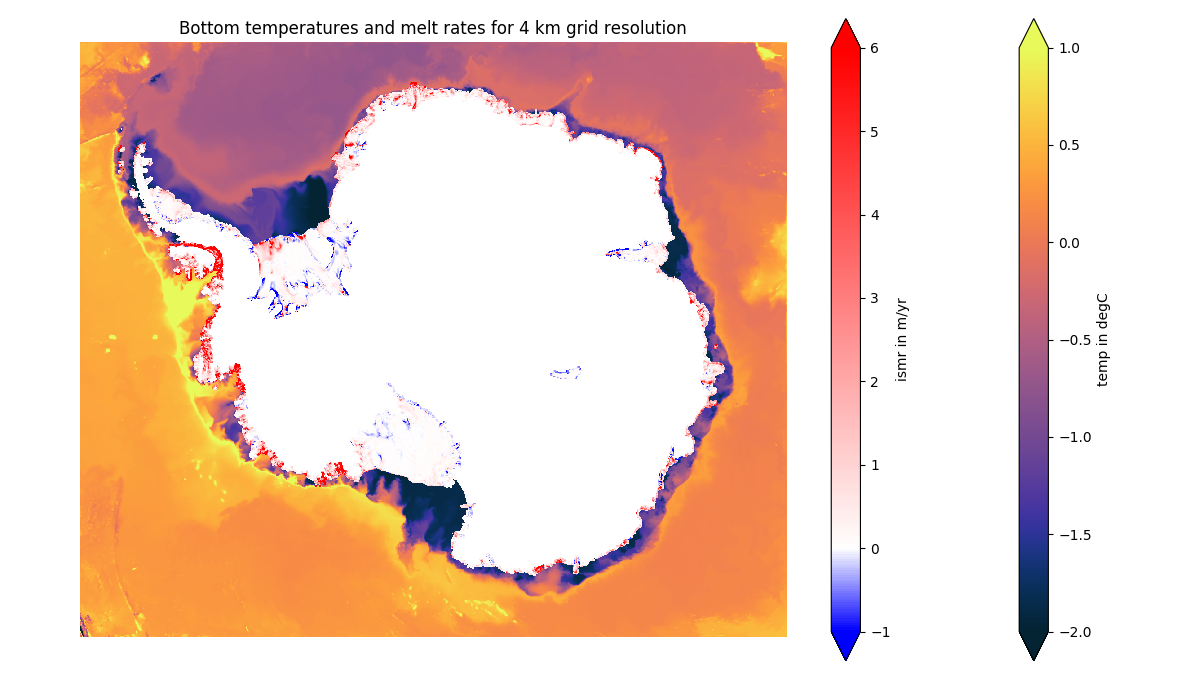

In [29]:
%matplotlib notebook
plot_m_bt(waom4_his,waom4_grd,'4')

<IPython.core.display.Javascript object>


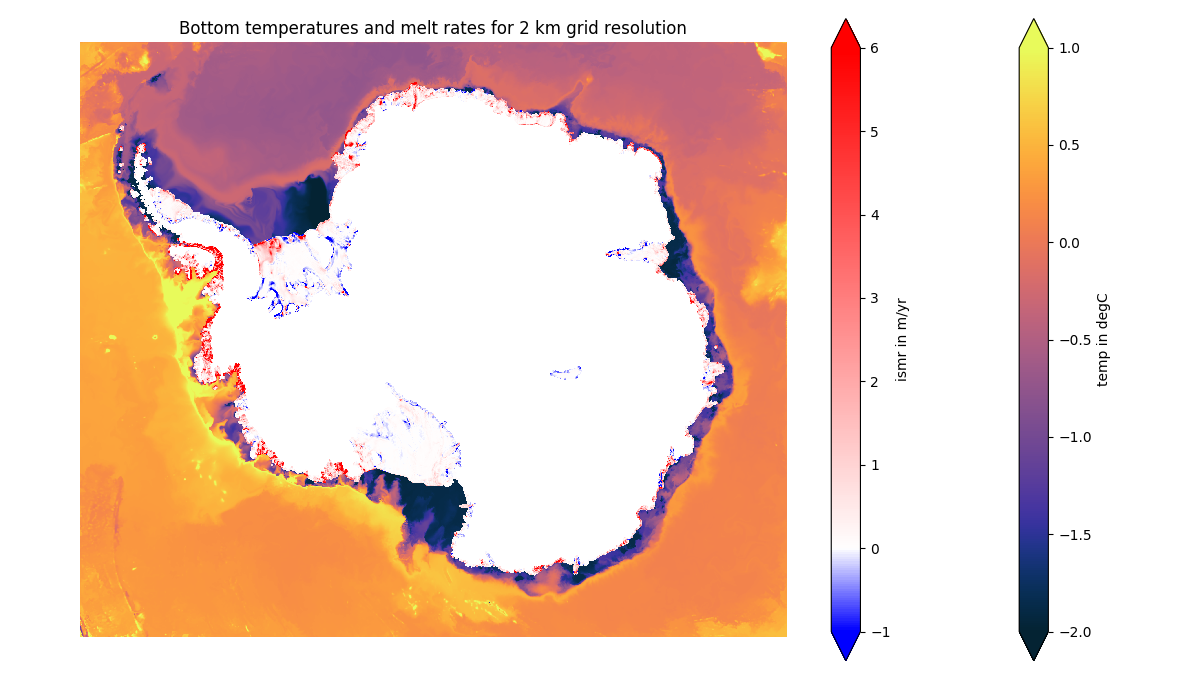

In [30]:
plot_m_bt(waom2_his,waom2_grd,'2')